In [67]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from models import make_model
import porepy as pp


model = make_model(
    {
        "physics": 1,
        "geometry": 2,
        "barton_bandis_stiffness_type": 2,
        "friction_type": 1,
        "grid_refinement": 1,
        "solver": 2,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
    load_data(f"../stats/{model.simulation_name()}.json"), 0
)
model.linear_system = mat, rhs
model.bmat.mat = mat



Sim time: 0, Dt: 0.5
sticking: 43, sliding: 0, open: 0


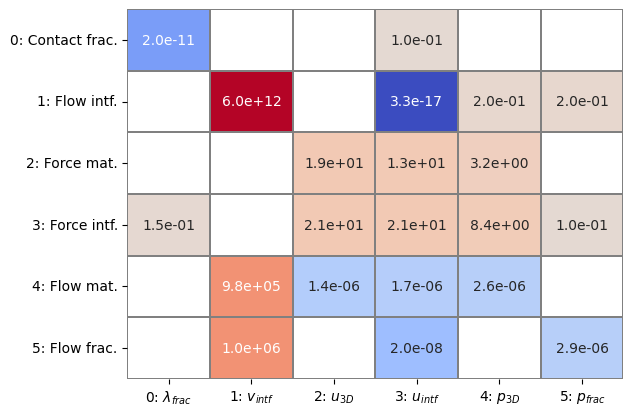

In [68]:
J = model.bmat[:]
J.plot_max()

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Solve  took: 0.25
True residual: 6.762245848615666e-10
PETSc Converged Reason: -3
lambda min: 0.5972788702194805


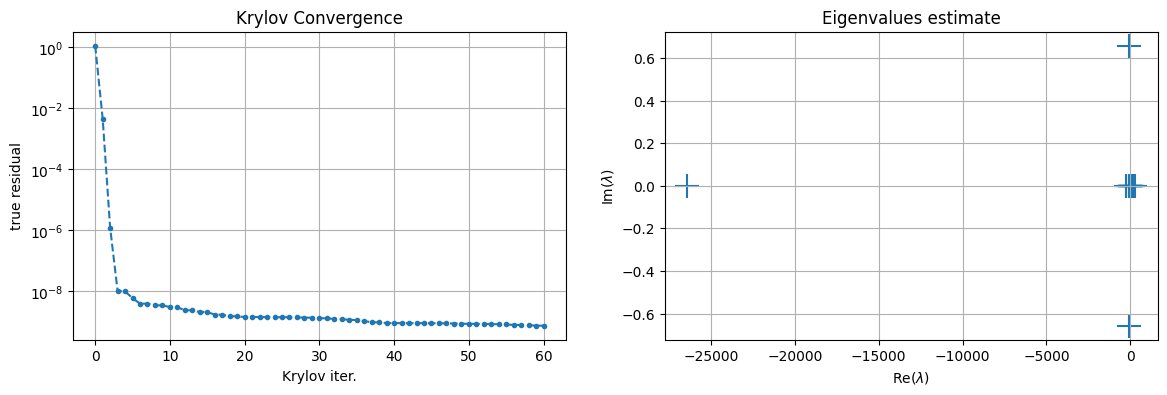

In [77]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        right_transformations=[
            lambda bmat: model.Qright(contact_group=0, u_intf_group=3)
        ],
        preconditioner=FieldSplitScheme(
            groups=[0],
            solve=lambda bmat: inv_block_diag(mat=bmat[[0]].mat, nd=model.nd),
            complement=FieldSplitScheme(
                groups=[1],
                # solve=lambda bmat: PetscILU(bmat[[1]].mat),
                # invertor=lambda bmat: extract_diag_inv(bmat[[1]].mat),
                complement=FieldSplitScheme(
                    groups=[2, 3],
                    # solve=lambda bmat: PetscAMGMechanics(
                    #     mat=bmat[[2, 3]].mat,
                    #     dim=model.nd,
                    #     null_space=build_mechanics_near_null_space(model),
                    # ),
                    invertor_type="physical",
                    invertor=lambda bmat: make_fs_analytical(
                        model, bmat, p_mat_group=4, p_frac_group=5
                    ).mat,
                    complement=FieldSplitScheme(
                        groups=[4, 5],
                        # solve=lambda bmat: PetscAMGFlow(mat=bmat[[4, 5]].mat, dim=model.nd),
                    ),
                ),
            ),
        ),
    ),
)

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


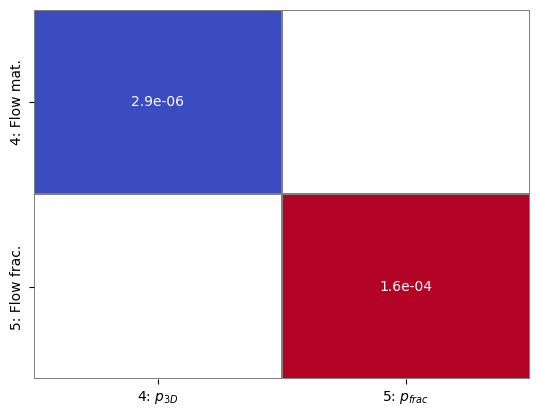

In [78]:
make_fs_analytical(model, J, p_mat_group=4, p_frac_group=5).plot_max()

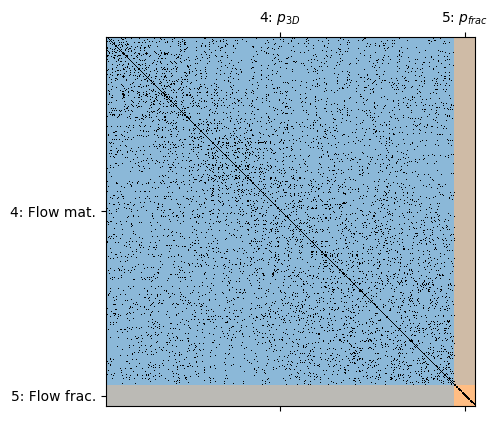

In [80]:
J[[4,5]].color_spy()